In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

We start by loading the previously created dataframe with the answers to the questions we asked gpt. We also read the 20 questions, which are stored in `questions` below.

In [2]:
romance_with_binary = pd.read_csv('./Data/Preprocessed/romances.with.binary.tsv', delimiter='\t')
romance_with_binary.head(3)

,index,movie_id,movie_name,revenue,runtime,languages,countries,movie_release,genres,imdb_id,rating,nb_votes,binary_answers
0,12,6631279,Little city,NaN,93.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},1997.0,"['Drama', 'Comedy', 'Romance', 'Ensemble']",tt0119548,5.8,1129.0,01001000000001111000
1,22,21926710,White on Rice,NaN,82.0,{},{'/m/09c7w0': 'United States of America'},2009.0,"['Comedy', 'Romance', 'Indie']",tt0892904,6.1,545.0,00000001000001000100
2,38,26067101,Siam Sunset,NaN,91.0,{},"{'/m/0chghy': 'Australia', '/m/0ctw_b': 'New Z...",1999.0,"['World Cinema', 'Comedy', 'Romance', 'Indie']",tt0178022,6.4,1240.0,01000000001000001000


In [3]:
f = open('Data/trope_questions.txt', 'r')

line = f.readline()
questions = []

while len(line)!=0:
    questions.append(line.strip())
    line = f.readline()
    
questions = questions[1:-1]

# A) Preprocessing

In [4]:
gpt_answers = romance_with_binary[['movie_id', 'binary_answers']].copy()
gpt_answers['response_length'] = gpt_answers['binary_answers'].apply(lambda ans: len(ans))
#gpt_answers.head(3)

In [5]:
bits = {'0', '1', '2'}
gpt_answers['binary_answers'] = gpt_answers['binary_answers'].apply(lambda b: ''.join(c for c in b if c in bits))
gpt_answers['response_length'] = gpt_answers['binary_answers'].apply(lambda ans: len(ans))

In [6]:
gpt_answers['binary_answers'] = gpt_answers['binary_answers'].apply(lambda b: b if len(b)==20 else '2'*20)
gpt_answers.drop(columns=['response_length'], inplace=True)
gpt_answers.head(5)

,movie_id,binary_answers
0,6631279,01001000000001111000
1,21926710,00000001000001000100
2,26067101,01000000001000001000
3,12053509,01000000000111011000
4,7028314,00010011010001001000


In [7]:
for q_nb, question in enumerate(questions):
    gpt_answers[f'q_{q_nb}'] = gpt_answers['binary_answers'].apply(lambda b: int(b[q_nb]))
    
gpt_answers.head(5)

,movie_id,binary_answers,q_0,q_1,q_2,q_3,q_4,q_5,q_6,q_7,...,q_10,q_11,q_12,q_13,q_14,q_15,q_16,q_17,q_18,q_19
0,6631279,01001000000001111000,0,1,0,0,1,0,0,0,...,0,0,0,1,1,1,1,0,0,0
1,21926710,00000001000001000100,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0
2,26067101,01000000001000001000,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
3,12053509,01000000000111011000,0,1,0,0,0,0,0,0,...,0,1,1,1,0,1,1,0,0,0
4,7028314,00010011010001001000,0,0,0,1,0,0,1,1,...,0,0,0,1,0,0,1,0,0,0


And let's plot how many answers to the questions were negative, positive and unknown for each question.

In [8]:
def plot(df):
    fig, ax = plt.subplots(4, 5, figsize= (20,8), sharey = True, sharex = True)

    for i in range(20):
        sbplt = ax[i%4, math.floor(i/4)]
        sbplt.hist(df[f'q_{i}'])
        sbplt.set_title(f'Question {i}')

    fig.tight_layout()
    fig.suptitle('Histogram of answers (0, 1, and 2) for each question', y=1.05, fontsize=20)
    plt.show()

#plot(gpt_answers)

In [9]:
def plot_pie_charts(df):
    fig, ax = plt.subplots(nrows = 4, ncols = 5, figsize = (12,10))

    for r in range(4):
        for c in range(5):
            ax[r,c].pie(df[f'q_{r*5+c}'].value_counts(),
                        labels = df[f'q_{r*5+c}'].dropna().unique(),
                        autopct=lambda p: '{:.1f}%'.format(p),
                        startangle=90, shadow=False)
            ax[r,c].set_title(f'Question {r*5+c}')
    
    fig.suptitle('Pie charts of percentage of answers (0, 1, and 2) for each question', y=1.01, fontsize=15)
    fig.tight_layout()
            
#plot_pie_charts(gpt_answers)

,movie_id,binary_answers,q_0,q_1,q_2,q_3,q_4,q_5,q_6,q_7,...,q_10,q_11,q_12,q_13,q_14,q_15,q_16,q_17,q_18,q_19
0,6631279,01001000000001111000,0,1,0,0,1,0,0,0,...,0,0,0,1,1,1,1,0,0,0
1,21926710,00000001000001000100,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0
2,26067101,01000000001000001000,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
3,12053509,01000000000111011000,0,1,0,0,0,0,0,0,...,0,1,1,1,0,1,1,0,0,0
4,7028314,00010011010001001000,0,0,0,1,0,0,1,1,...,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5877,4037444,00010100010001000000,0,0,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
5878,1191380,00001000110110100010,0,0,0,0,1,0,0,0,...,0,1,1,0,1,0,0,0,1,0
5879,54540,10000000001000010010,1,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,1,0
5880,1673588,00000001010000000000,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


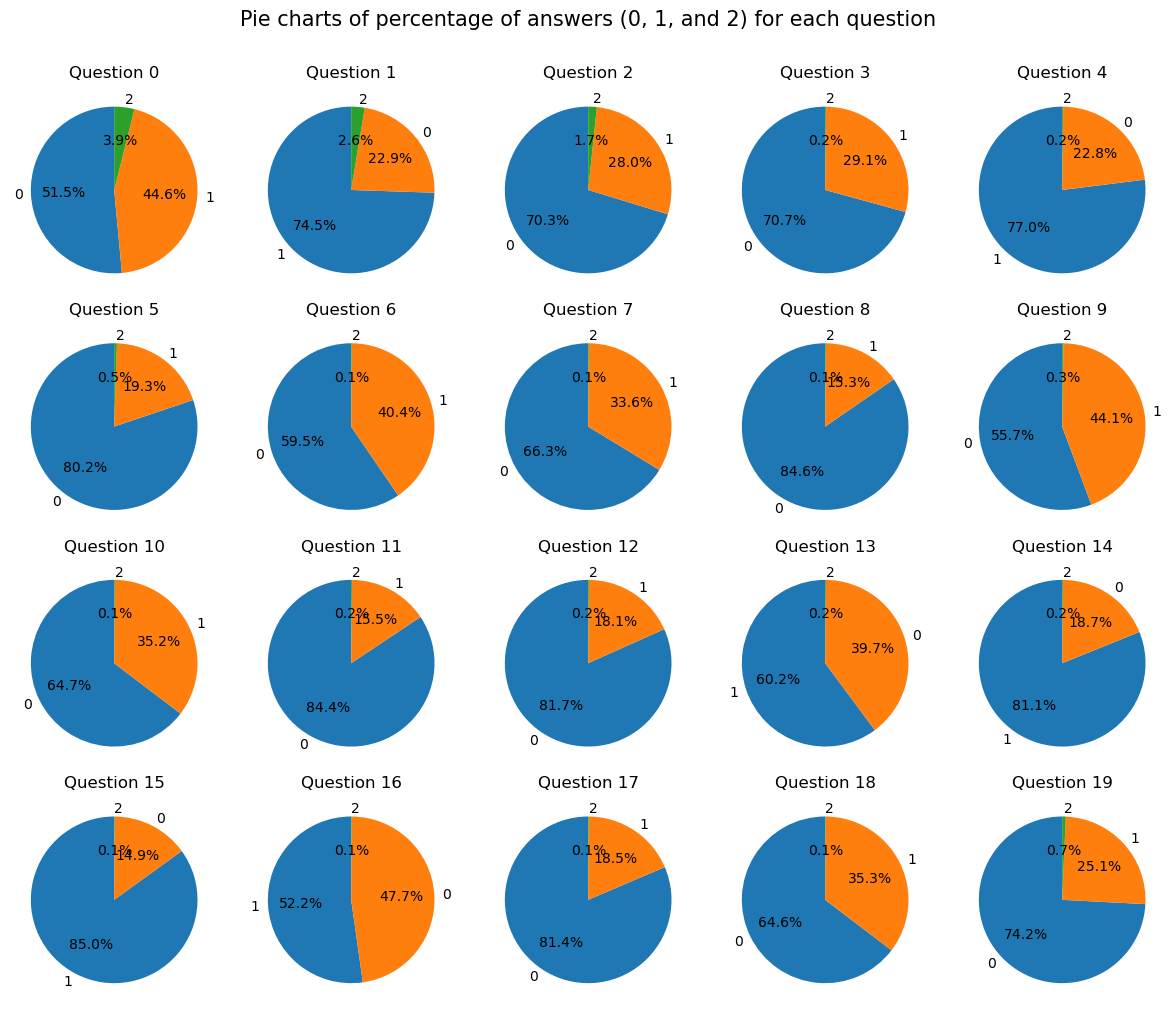

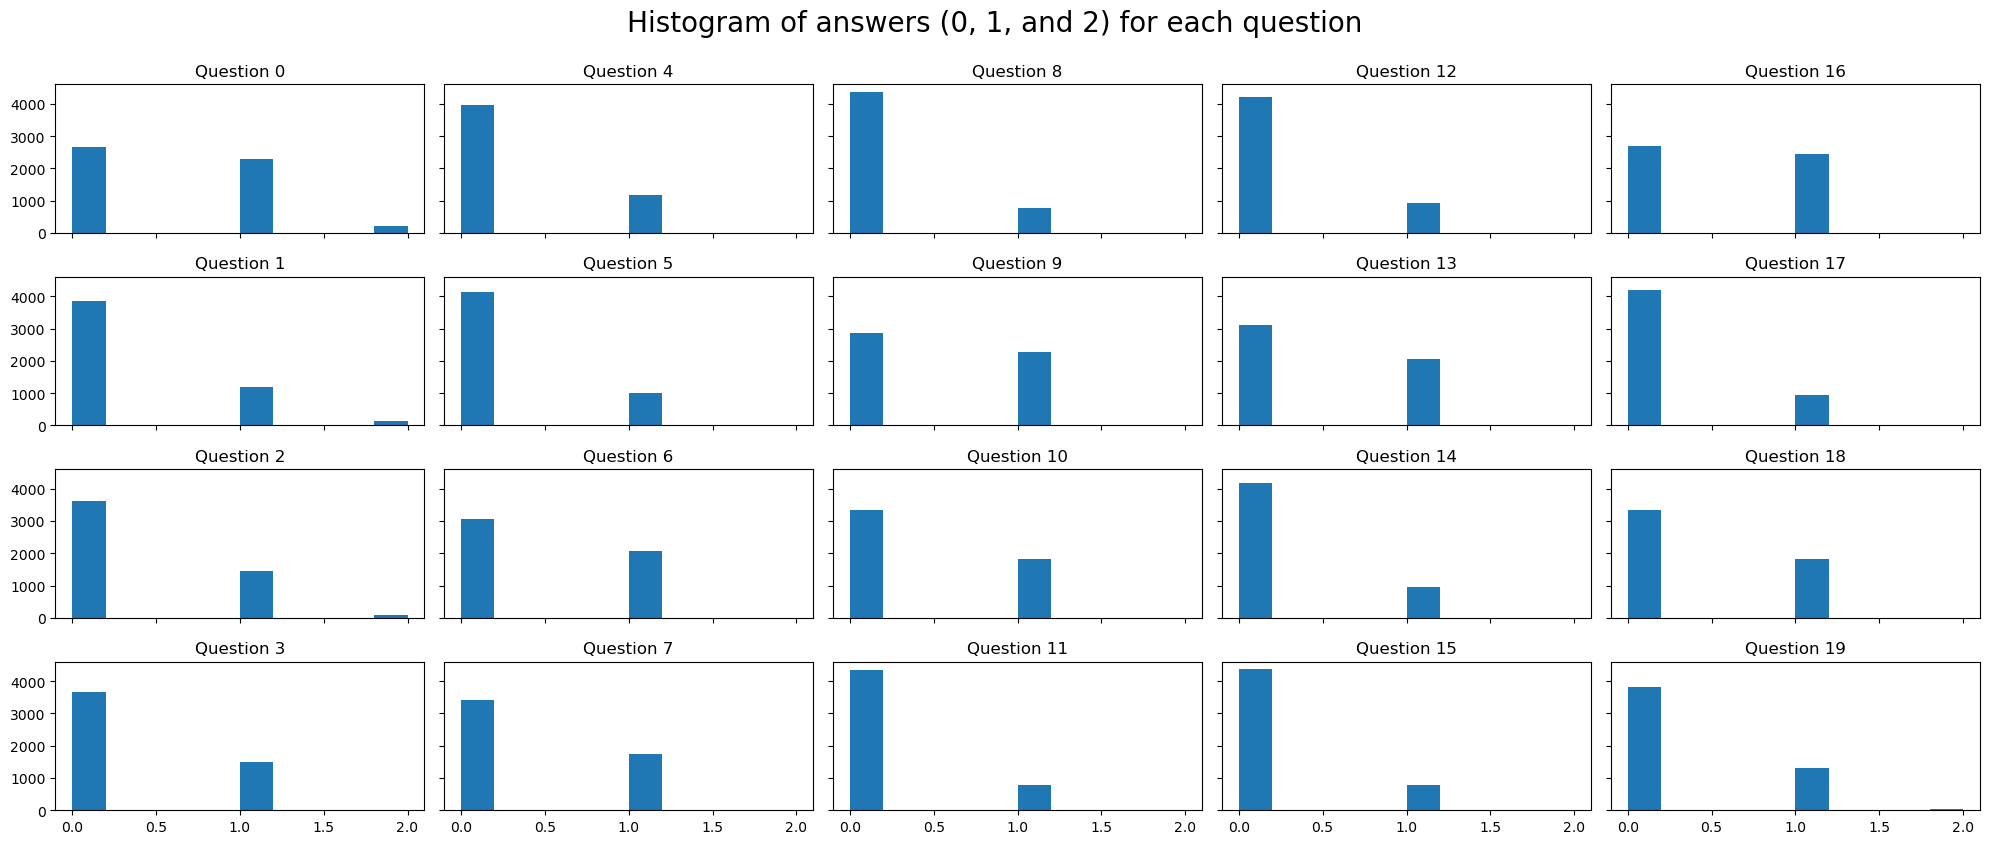

In [72]:
relevant_answers2 = relevant_answers[relevant_answers['binary_answers'].str.contains('1')].copy()
relevant_answers = gpt_answers[gpt_answers['binary_answers']!='2'*20].copy()
plot_pie_charts(relevant_answers2)
plot(relevant_answers2)

In [73]:
col_to_keep = ['movie_id', 'movie_release', 'binary_answers']
for i in range(len(questions)):
    col_to_keep.append(f'q_{i}')
    
#right merge because we only care about the relevant answers
gpt_year = romance_with_binary.merge(relevant_answers2, on=['movie_id', 'binary_answers'], how='right')[col_to_keep]
gpt_year.replace(2, np.NaN, inplace=True)

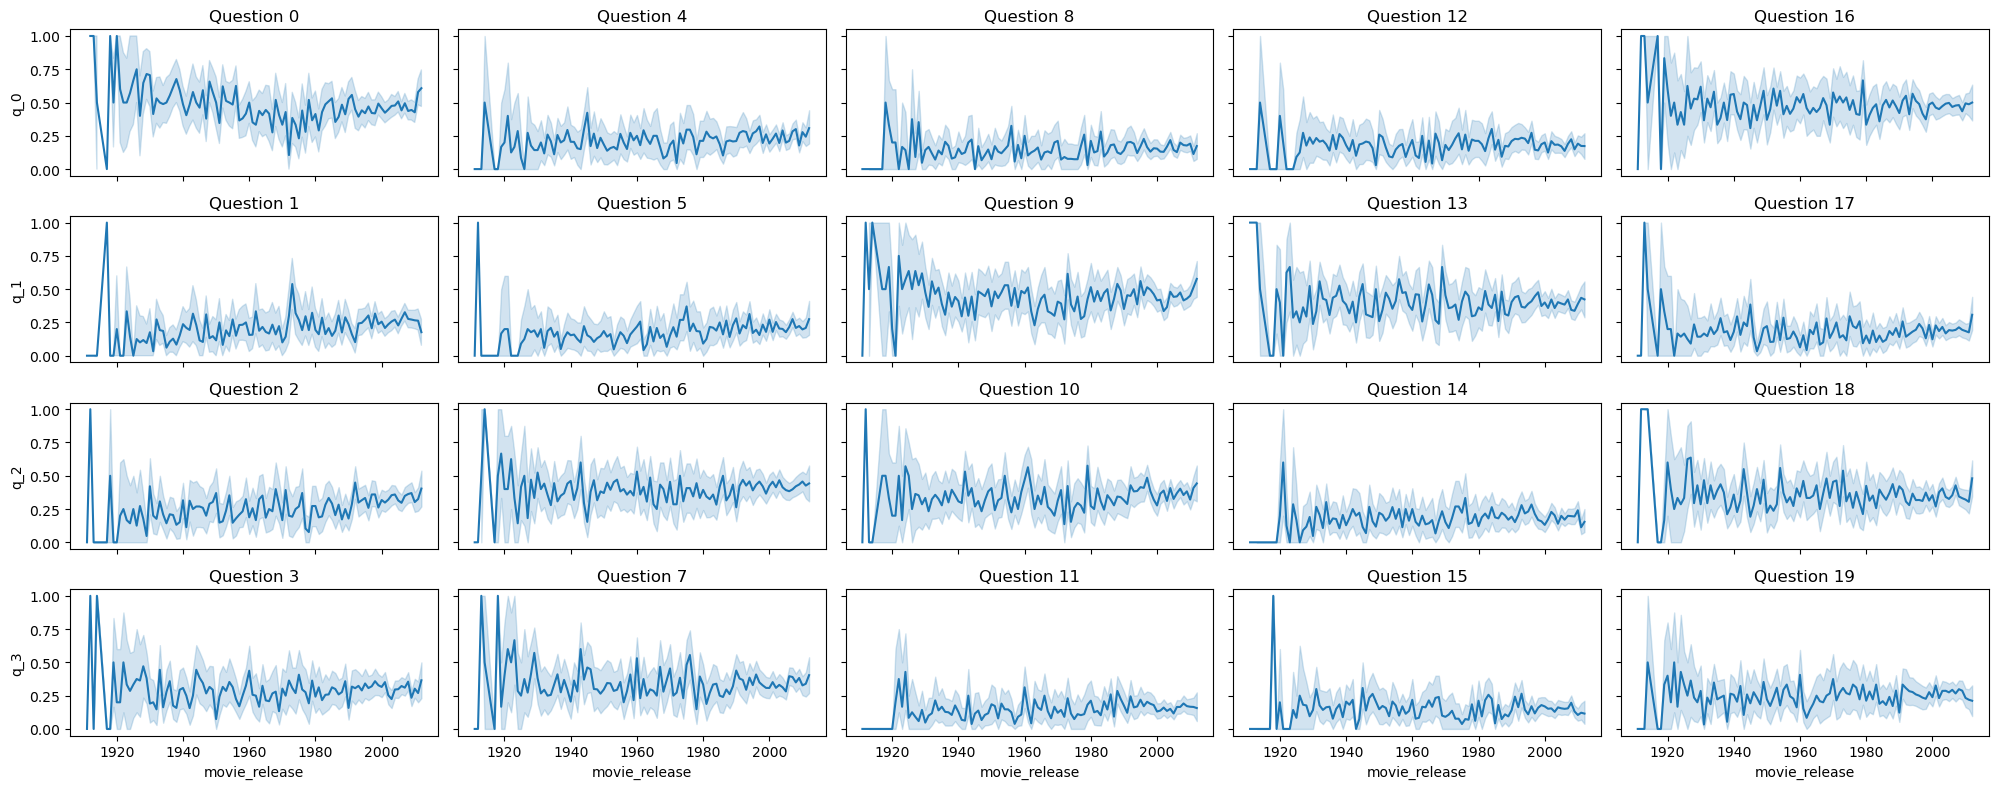

In [74]:
def plot_answer_by_year(df): 
    fig, ax = plt.subplots(4, 5, figsize= (20,8), sharey = True, sharex = True)

    for i in range(20):
        ax[i%4, math.floor(i/4)].set_title(f'Question {i}')
        sns.lineplot(df, x='movie_release', y=f'q_{i}', ax=ax[i%4, math.floor(i/4)])

    fig.tight_layout()
    plt.show()
    
plot_answer_by_year(gpt_year)

In [13]:
#plot_answer_by_year(gpt_year[gpt_year['movie_release']>1920])

We now have `relevant_answers` which consists of all movies we can analyze.

# B) Analysis of single questions

In [14]:
display(relevant_answers.iloc[24])

movie_id                       5254729
binary_answers    22200000001000000110
q_0                                  2
q_1                                  2
q_2                                  2
q_3                                  0
q_4                                  0
q_5                                  0
q_6                                  0
q_7                                  0
q_8                                  0
q_9                                  0
q_10                                 1
q_11                                 0
q_12                                 0
q_13                                 0
q_14                                 0
q_15                                 0
q_16                                 0
q_17                                 1
q_18                                 1
q_19                                 0
Name: 24, dtype: object

In [77]:
trimmed = relevant_answers2.drop(['binary_answers'], axis = 1)
trimmed = trimmed.replace(2, np.NaN)
df = trimmed.merge(romance_with_binary, on = 'movie_id', how = 'left')
display(df)

,movie_id,q_0,q_1,q_2,q_3,q_4,q_5,q_6,q_7,q_8,...,revenue,runtime,languages,countries,movie_release,genres,imdb_id,rating,nb_votes,binary_answers
0,6631279,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,NaN,93.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},1997.0,"['Drama', 'Comedy', 'Romance', 'Ensemble']",tt0119548,5.8,1129.0,01001000000001111000
1,21926710,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,NaN,82.0,{},{'/m/09c7w0': 'United States of America'},2009.0,"['Comedy', 'Romance', 'Indie']",tt0892904,6.1,545.0,00000001000001000100
2,26067101,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,91.0,{},"{'/m/0chghy': 'Australia', '/m/0ctw_b': 'New Z...",1999.0,"['World Cinema', 'Comedy', 'Romance', 'Indie']",tt0178022,6.4,1240.0,01000000001000001000
3,12053509,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3960327.0,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},1989.0,"['Comedy', 'Romance']",tt0097790,6.0,8597.0,01000000000111011000
4,7028314,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,3600000.0,90.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},1957.0,"['Comedy', 'Romance']",tt0050646,5.6,1003.0,00010011010001001000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5254,4037444,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,NaN,100.0,{'/m/01gp_d': 'Finnish Language'},"{'/m/02vzc': 'Finland', '/m/0d0vqn': 'Sweden'}",2004.0,"['Comedy', 'Romance', 'LGBT', 'World Cinema', ...",tt0366701,6.1,1313.0,00010100010001000000
5255,1191380,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,2158775.0,118.0,{'/m/02h40lc': 'English Language'},"{'/m/014tss': 'Kingdom of Great Britain', '/m/...",1997.0,"['Romance', 'Biopic', 'History', 'LGBT', 'Worl...",tt0120514,6.9,17890.0,00001000110110100010
5256,54540,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,288752301.0,117.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},1988.0,"['Drama', 'Comedy', 'Romance']",tt0094898,7.1,218787.0,10000000001000010010
5257,1673588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,NaN,104.0,"{'/m/02h40lc': 'English Language', '/m/06nm1':...",{'/m/09c7w0': 'United States of America'},1984.0,"['Comedy', 'Romance', 'Indie', 'Religious', 'F...",tt0087004,6.8,6422.0,00000001010000000000


6.501583793738489 6.309918768704575


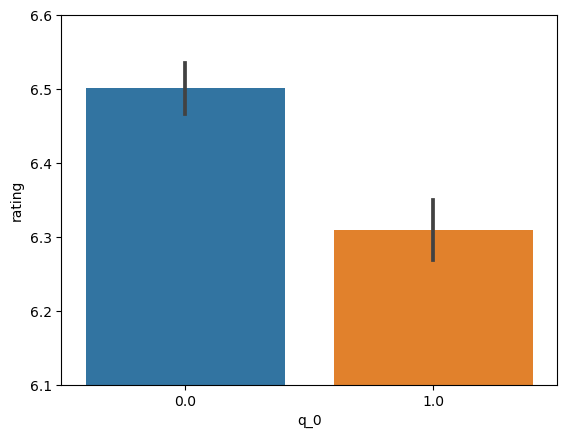

In [79]:
sns.barplot(df, x= 'q_0', y='rating')
plt.ylim(6.1,6.6)

print(df[df.q_0 == 0]['rating'].mean(), df[df.q_0 == 1]['rating'].mean())

In [80]:
df["ratings_with_weight"] = [ v + w*1j for v,w in zip(df.rating, df.nb_votes)]
def weighted_mean(x, **kws):
    return np.sum(np.real(x) * np.imag(x)) / np.sum(np.imag(x))

display(df)


#def weighted_mean(x, **kws):
#    val, weight = map(np.asarray, zip(*x))
#    return (val * weight).sum() / weight.sum()

,movie_id,q_0,q_1,q_2,q_3,q_4,q_5,q_6,q_7,q_8,...,runtime,languages,countries,movie_release,genres,imdb_id,rating,nb_votes,binary_answers,ratings_with_weight
0,6631279,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,93.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},1997.0,"['Drama', 'Comedy', 'Romance', 'Ensemble']",tt0119548,5.8,1129.0,01001000000001111000,5.8+ 1129.0j
1,21926710,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,82.0,{},{'/m/09c7w0': 'United States of America'},2009.0,"['Comedy', 'Romance', 'Indie']",tt0892904,6.1,545.0,00000001000001000100,6.1+ 545.0j
2,26067101,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,91.0,{},"{'/m/0chghy': 'Australia', '/m/0ctw_b': 'New Z...",1999.0,"['World Cinema', 'Comedy', 'Romance', 'Indie']",tt0178022,6.4,1240.0,01000000001000001000,6.4+ 1240.0j
3,12053509,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},1989.0,"['Comedy', 'Romance']",tt0097790,6.0,8597.0,01000000000111011000,6.0+ 8597.0j
4,7028314,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,90.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},1957.0,"['Comedy', 'Romance']",tt0050646,5.6,1003.0,00010011010001001000,5.6+ 1003.0j
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5254,4037444,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,100.0,{'/m/01gp_d': 'Finnish Language'},"{'/m/02vzc': 'Finland', '/m/0d0vqn': 'Sweden'}",2004.0,"['Comedy', 'Romance', 'LGBT', 'World Cinema', ...",tt0366701,6.1,1313.0,00010100010001000000,6.1+ 1313.0j
5255,1191380,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,118.0,{'/m/02h40lc': 'English Language'},"{'/m/014tss': 'Kingdom of Great Britain', '/m/...",1997.0,"['Romance', 'Biopic', 'History', 'LGBT', 'Worl...",tt0120514,6.9,17890.0,00001000110110100010,6.9+ 17890.0j
5256,54540,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,117.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},1988.0,"['Drama', 'Comedy', 'Romance']",tt0094898,7.1,218787.0,10000000001000010010,7.1+218787.0j
5257,1673588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,104.0,"{'/m/02h40lc': 'English Language', '/m/06nm1':...",{'/m/09c7w0': 'United States of America'},1984.0,"['Comedy', 'Romance', 'Indie', 'Religious', 'F...",tt0087004,6.8,6422.0,00000001010000000000,6.8+ 6422.0j


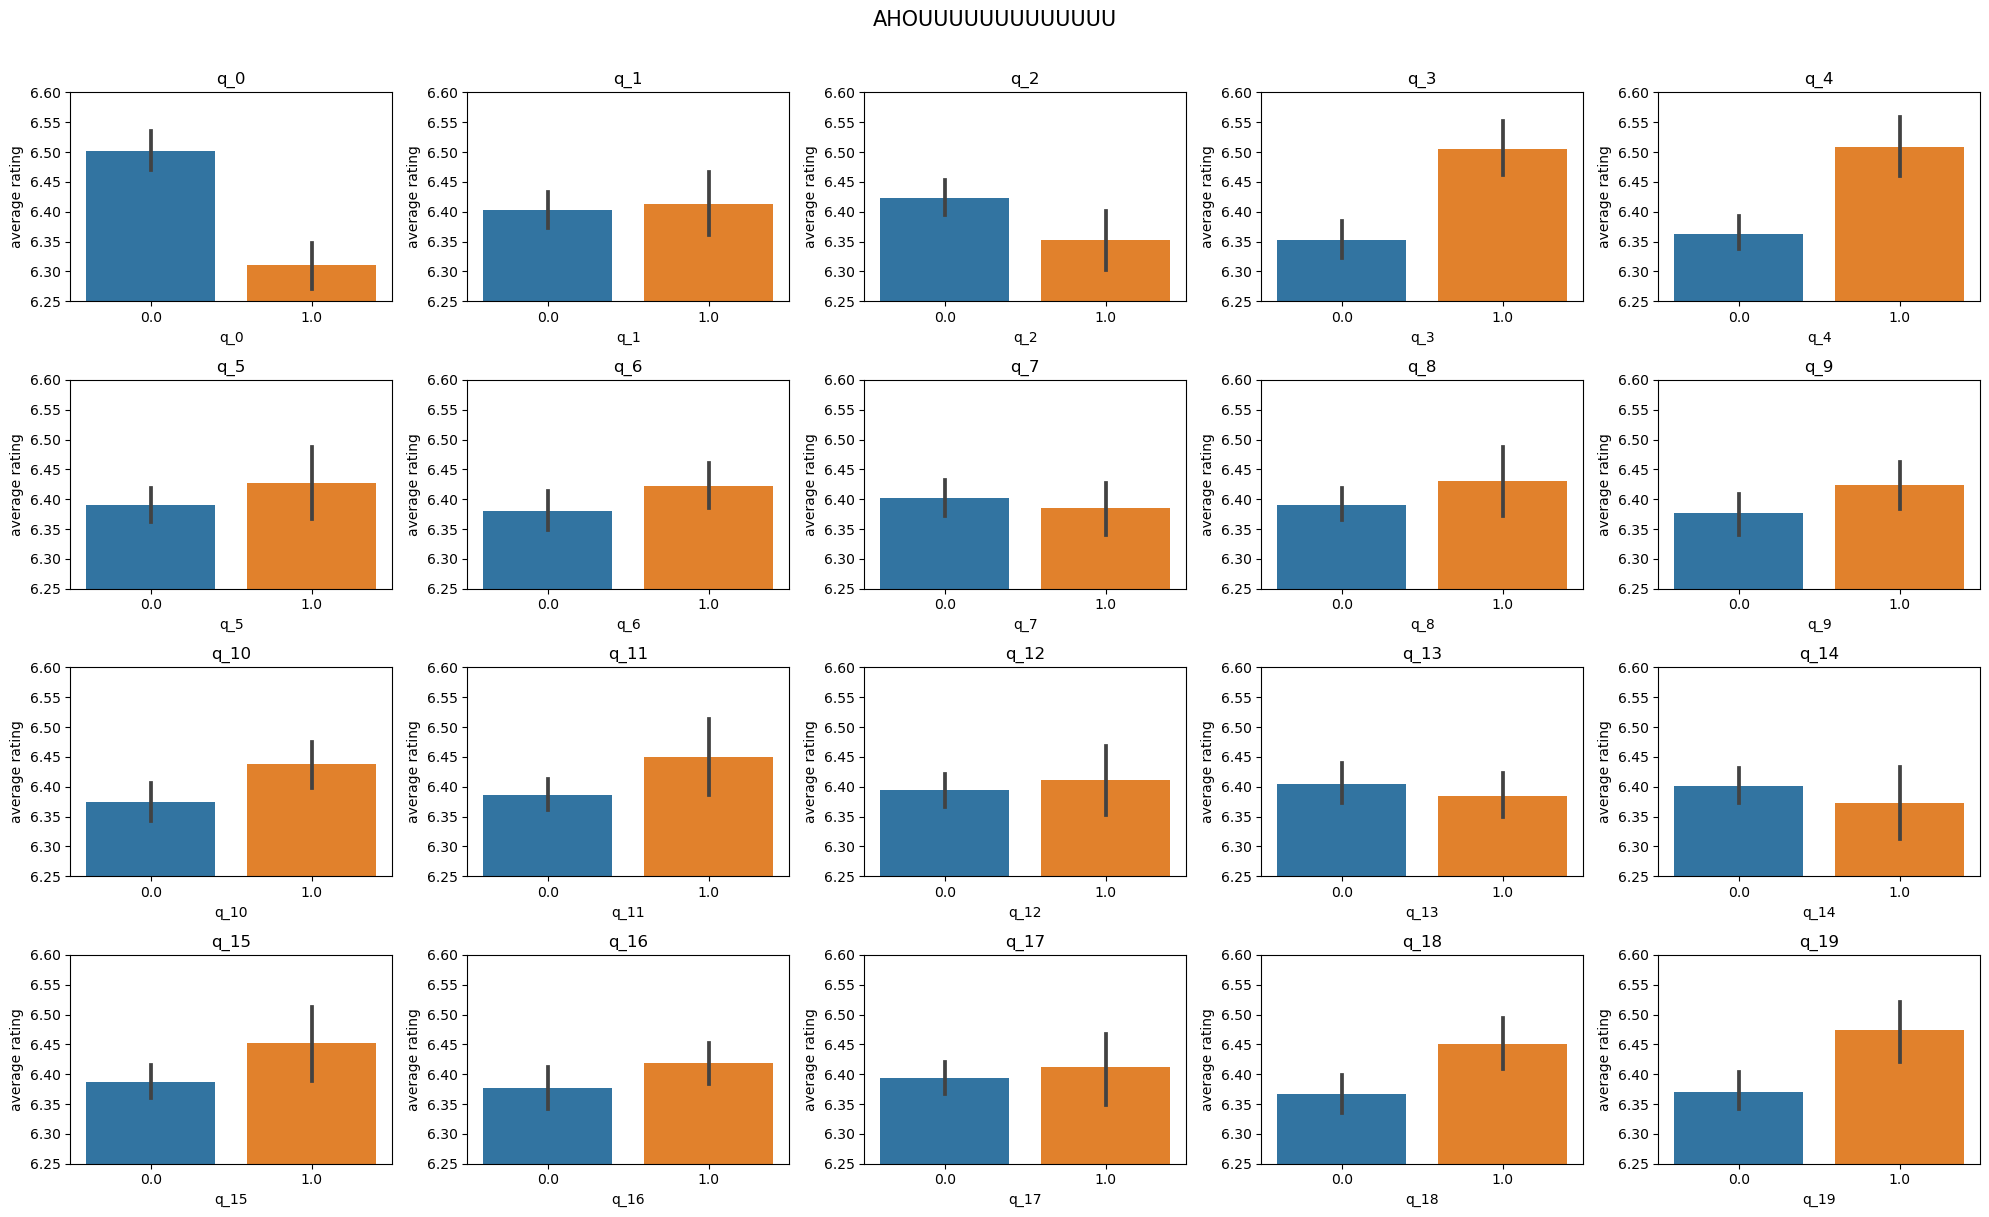

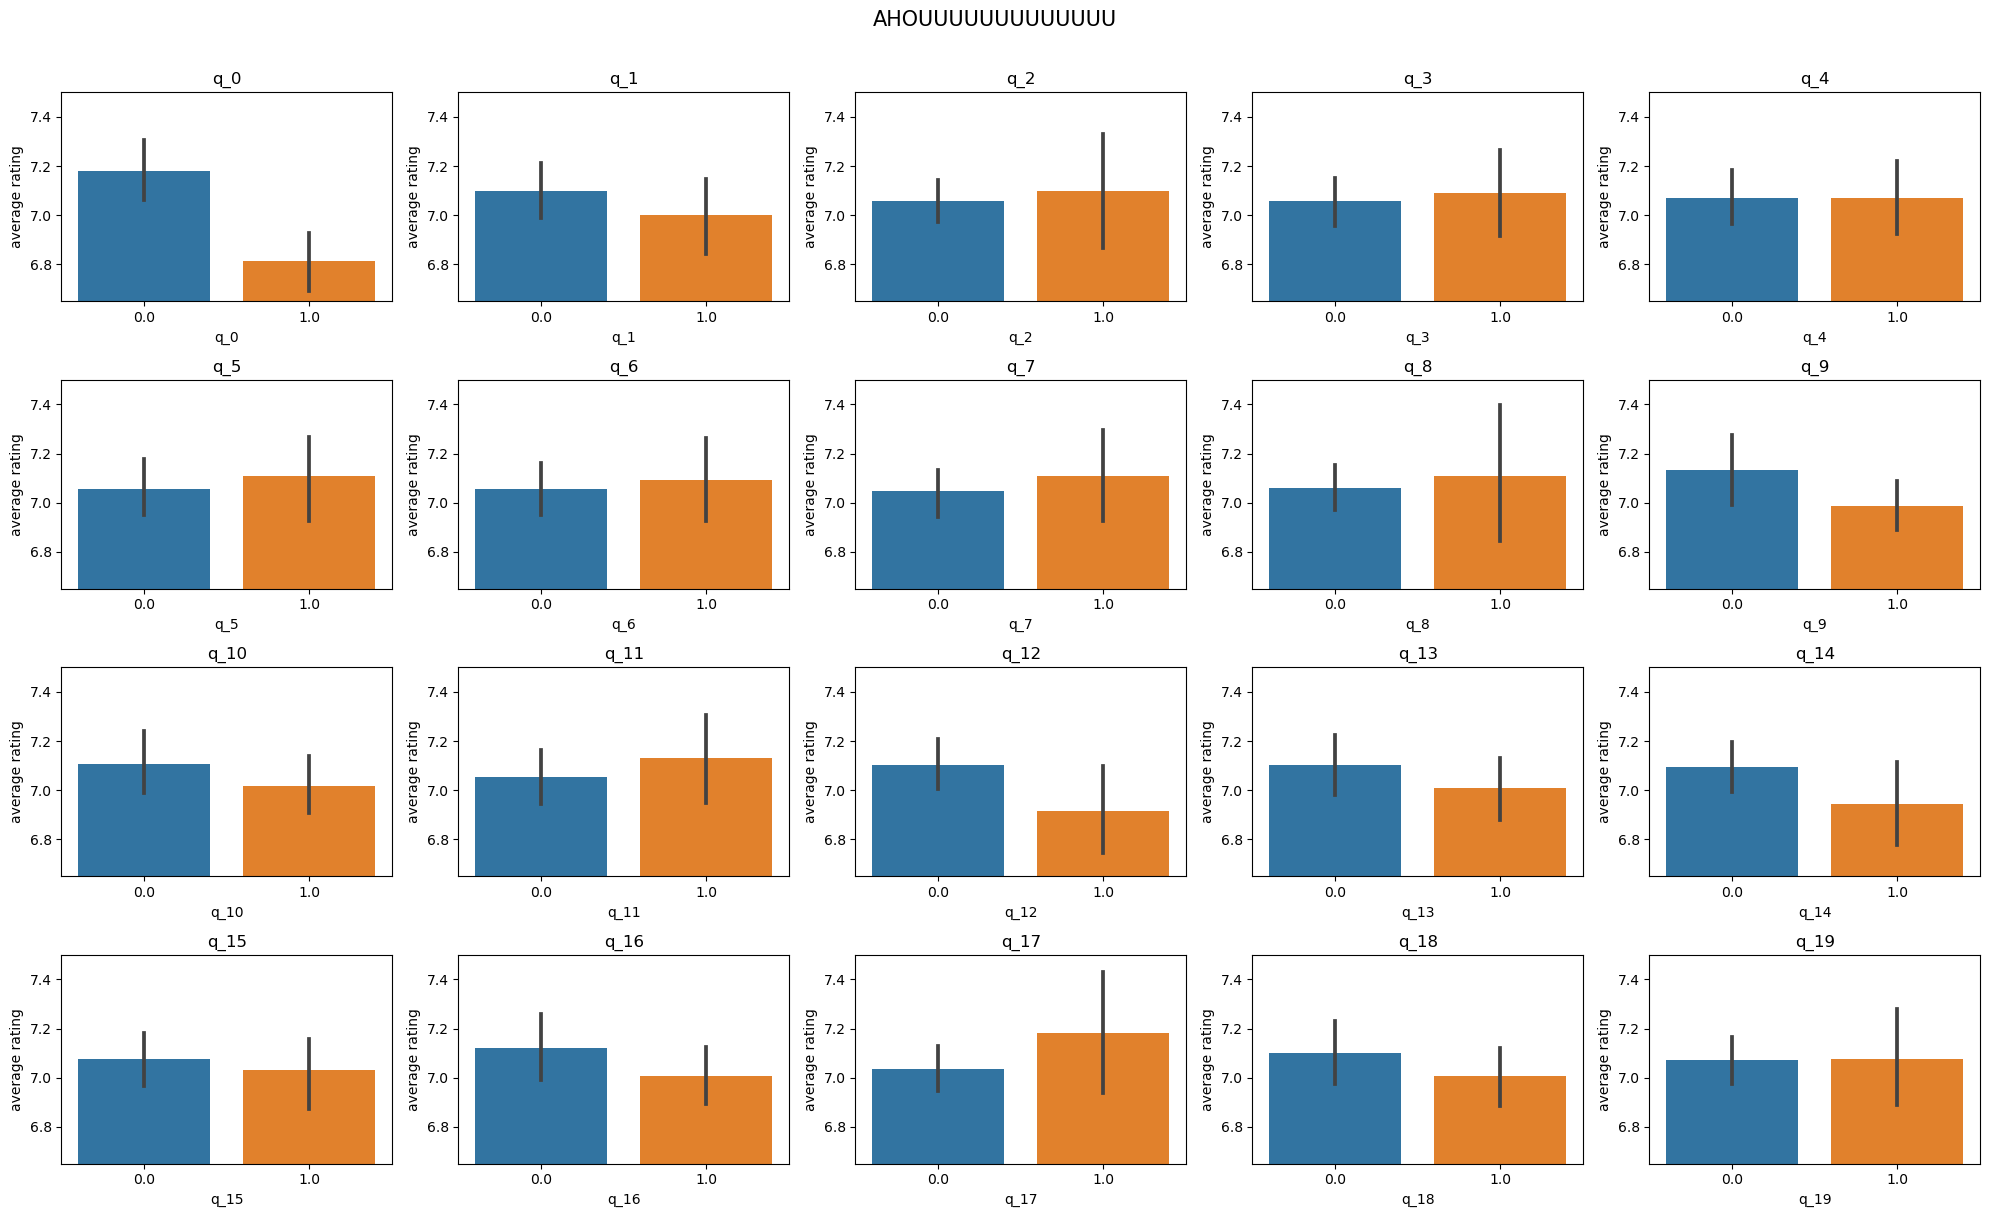

In [81]:
def plot_error_bars(df, nr_rows, nr_cols, weights):
    
    fig, ax = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*4,nr_rows*3), squeeze=False)
    
    for r in range(nr_rows):
        for c in range(nr_cols):
            
            index = r * 5 + c
            question = 'q_' + str(index)
            
            if weights : 
                sns.barplot(df, x= question, y='ratings_with_weight', ax = ax[r][c], estimator = weighted_mean, errorbar=('ci', 95))
                ax[r][c].set_ylim(6.65,7.5)
            else :
                sns.barplot(df, x= question, y='rating', ax = ax[r][c])
                ax[r][c].set_ylim(6.25,6.6)

            ax[r][c].set_ylabel('average rating')
            ax[r][c].set_title(question)
            #ax[r,c].set_title(question)
    
    fig.suptitle('AHOUUUUUUUUUUUUU', y=1.01, fontsize=15)
    plt.tight_layout()    
    plt.show()
            
        
        
plot_error_bars(df,4,5, False)
plot_error_bars(df,4,5, True)
#for i in range(19) :
#    sns.barplot(new_df, x= 'q_18', y='rating')
#plt.ylim(6.1,6.6)

# C) Analysis of ratings

In [61]:
display(df)

,index,movie_id,movie_name,revenue,runtime,languages,countries,movie_release,genres,imdb_id,...,q_11,q_12,q_13,q_14,q_15,q_16,q_17,q_18,q_19,ratings_with_weight
0,12,6631279,Little city,NaN,93.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},1997.0,"['Drama', 'Comedy', 'Romance', 'Ensemble']",tt0119548,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,5.8+ 1129.0j
1,22,21926710,White on Rice,NaN,82.0,{},{'/m/09c7w0': 'United States of America'},2009.0,"['Comedy', 'Romance', 'Indie']",tt0892904,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,6.1+ 545.0j
2,38,26067101,Siam Sunset,NaN,91.0,{},"{'/m/0chghy': 'Australia', '/m/0ctw_b': 'New Z...",1999.0,"['World Cinema', 'Comedy', 'Romance', 'Indie']",tt0178022,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6.4+ 1240.0j
3,61,12053509,Loverboy,3960327.0,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},1989.0,"['Comedy', 'Romance']",tt0097790,...,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,6.0+ 8597.0j
4,88,7028314,The Little Hut,3600000.0,90.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},1957.0,"['Comedy', 'Romance']",tt0050646,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,5.6+ 1003.0j
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5991,82079,4037444,Producing Adults,NaN,100.0,{'/m/01gp_d': 'Finnish Language'},"{'/m/02vzc': 'Finland', '/m/0d0vqn': 'Sweden'}",2004.0,"['Comedy', 'Romance', 'LGBT', 'World Cinema', ...",tt0366701,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6.1+ 1313.0j
5992,82094,1191380,Wilde,2158775.0,118.0,{'/m/02h40lc': 'English Language'},"{'/m/014tss': 'Kingdom of Great Britain', '/m/...",1997.0,"['Romance', 'Biopic', 'History', 'LGBT', 'Worl...",tt0120514,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,6.9+ 17890.0j
5993,82095,54540,Coming to America,288752301.0,117.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},1988.0,"['Drama', 'Comedy', 'Romance']",tt0094898,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,7.1+218787.0j
5994,82097,1673588,The Brother from Another Planet,NaN,104.0,"{'/m/02h40lc': 'English Language', '/m/06nm1':...",{'/m/09c7w0': 'United States of America'},1984.0,"['Comedy', 'Romance', 'Indie', 'Religious', 'F...",tt0087004,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.8+ 6422.0j
